<a href="https://colab.research.google.com/github/vanithakattumuri/PAMI/blob/main/notebooks/highUtilitySpatialPattern/basic/HDSHUIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding High Utility Spatial Patterns in Utility Databases using HDSHUIM

This tutorial has two parts. In the first part, we describe the basic approach to find High Utility Spatial Patterns in a Utility database using the HDSHUIM algorithm. In the final part, we describe an advanced approach, where we evaluate the HDSHUIM algorithm on a dataset at different minimum utility threshold values.
***

# Prerequisites:



1.   Installing the PAMI library

In [1]:
!pip install -U pami #install the pami repository

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.0/835.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3313 sha256=000ff94182748f00b1c232a1991d5790718238fa349c687e7d531015a051f51b
  Stored in directory: /root/.cache/pip/wheels/b6/e5/87/11026246d3bd4ad67c0615682d2d6748bbd9a40ac0490882bd
  Created wheel for JsonSir: filename=JsonSir-0.0.2-py3-none-any.whl size=4750 sha256=d8d1e2ab720d98ed6403be8f3a05a2a984b77d70822329e96f80308038c1e7a2
  Stored in directory: /root/.cache/pip/wheels/1d/4c/d3/4d9757425983b43eb709be1043d82cd03fb863ce5f56f117e6
Successfully built JsonForm JsonSir


2.   Downloading a sample dataset

In [2]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/utilityDatabases/Utility_T10I4D100K.csv #download a sample utility database

--2023-09-08 17:43:22--  https://u-aizu.ac.jp/~udayrage/datasets/utilityDatabases/Utility_T10I4D100K.csv
Resolving u-aizu.ac.jp (u-aizu.ac.jp)... 150.31.244.160, 150.95.161.176
Connecting to u-aizu.ac.jp (u-aizu.ac.jp)|150.31.244.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7356594 (7.0M) [text/csv]
Saving to: ‘Utility_T10I4D100K.csv’

Utility_T10I4D100K. 100%[===================>]   7.02M  1.72MB/s    in 4.1s    

2023-09-08 17:43:27 (1.72 MB/s) - ‘Utility_T10I4D100K.csv’ saved [7356594/7356594]



3.   Printing few lines of a dataset to know its format.

In [3]:
!head -2 Utility_T10I4D100K.csv

25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834:852:25	96	32	50	20	80	48	58	75	86	64	57	16	14	46	85 
39	120	124	205	401	581	704	814	825	834:396:6	60	42	58	31	53	10	52	22	62 


format: every row contains items seperated by a seperator.

Example:

item1 item2 item3 item4

item1 item4 item6
***

## Part 1: Finding High Utility Spatial Patterns using HDSHUIM

### Step 1: Understanding the statistics of a database to choose an appropriate minimum Support (minSup) value.

In [4]:
#import the class file
import PAMI.extras.dbStats.UtilityDatabase as stats

#specify the file name
inputFile = 'Utility_T10I4D100K.csv'

#initialize the class
obj=stats.UtilityDatabase(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to print all of the database statistics and plot them
# obj.printStats()
# obj.plotGraphs()

Database size : 99935
Total number of items : 870
Database sparsity : 0.9883886940304302
Minimum Transaction Size : 1
Average Transaction Size : 10.101836193525791
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667097909135199
Variance in Transaction Sizes : 13.447741640067324


### Step 2: Draw the item's frequency graph and transaction length's distribution graphs for more information

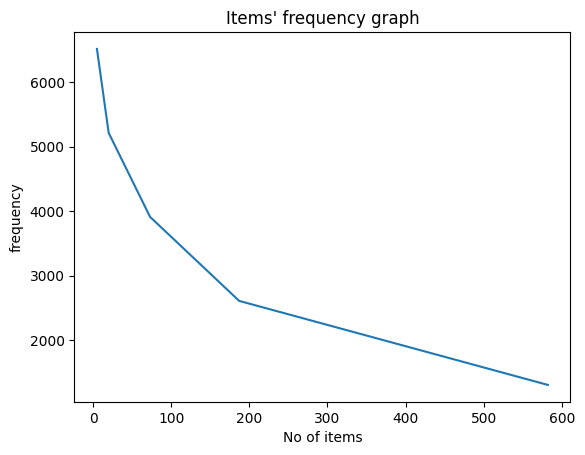

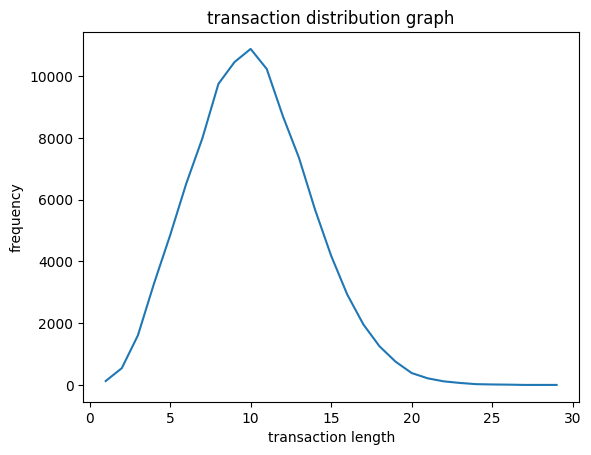

In [5]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, end = 100, title = 'Items\' frequency graph', xlabel = 'No of items', ylabel= 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, end = 100, title = 'transaction distribution graph', xlabel = 'transaction length', ylabel = 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 10000 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.

In [6]:
neighborFile = 'mushroom_neighbourhood.txt'
#minUtilCount = 10000
minSup = 10000  #minSup is specified in count. However, the users can also specify minSup between 0 and 1.

### Step 4: Mining High Utility Spatial Patterns using HDSHUIM

In [9]:
from PAMI.highUtilitySpatialPattern.basic import HDSHUIM as alg#import the algorithm

obj = alg.HDSHUIM(iFile=inputFile, nFile=neighborFile, minUtil=minSup, sep='\t') #initialize
obj.mine()            #start the mining process

obj.save('utilityFrequentPatternsAtMinUtilCount10000.txt') #save the patterns


frequentPatternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(len(frequentPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

Total No of patterns: 869
Runtime: 13.489856719970703
Memory (RSS): 467300352
Memory (USS): 420933632


### Step 5: Investigating the generated patterns

Open the pattern's file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minUtil_ value.

In [10]:
!head 'utilityFrequentPatternsAtMinUtilCount10000.txt'

619:237 
245:243 
502:532 
850:534 
564:590 
768:616 
725:703 
360:730 
282:748 
121:931 


The storage format is: _highUtilityPattern:support_
***

## Part 2: Evaluating the HDSHUIM algorithm on a dataset at different minUtilCount values

### Step 1: Import the libraries and specify the input parameters

In [11]:
#Import the libraries
from PAMI.highUtilitySpatialPattern.basic import HDSHUIM as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Utility_T10I4D100K.csv'
neighborFile = 'mushroom_neighbourhood.txt'
seperator='\t'
minimumSupportCountList = [10000, 20000, 30000, 40000, 50000]
#minimumSupportCountList can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

### Step 2: Create a data frame to store the results of HDSHUIM

In [12]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of HDSHUIM algorithm

### Step 3: Execute the algorithm at different minSup values

In [13]:
for minSup in minimumSupportCountList:
    obj = alg.HDSHUIM(iFile=inputFile, nFile=neighborFile, minUtil=minSup, sep=seperator)
    obj.mine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['HDSHUIM', minSup, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

### Step 4: Print the Result

In [14]:
print(result)

  algorithm  minSup  patterns    runtime     memory
0   HDSHUIM   10000       742  14.773274  464658432
1   HDSHUIM   20000       628  13.044893  459792384
2   HDSHUIM   30000       515  12.799663  448946176
3   HDSHUIM   40000       446  11.866458  443785216
4   HDSHUIM   50000       374  13.263564  434495488


### Step 5: Visualizing the results

<Axes: xlabel='minSup'>

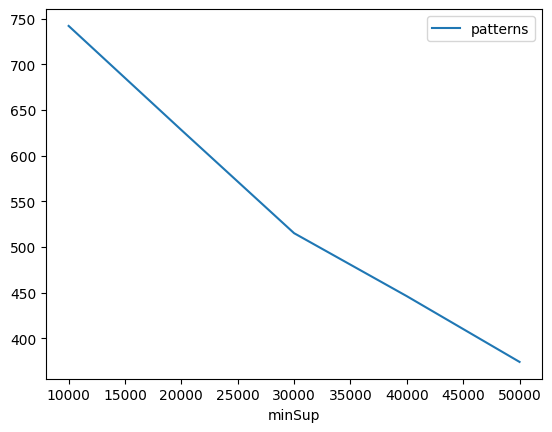

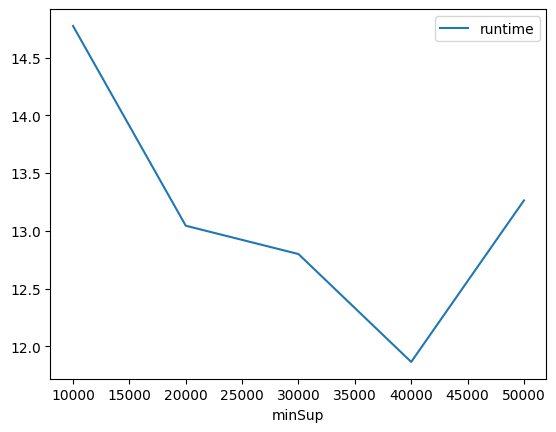

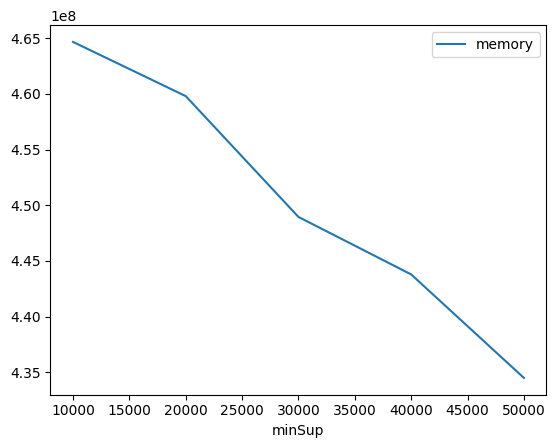

In [15]:
result.plot(x='minSup', y='patterns', kind='line')
result.plot(x='minSup', y='runtime', kind='line')
result.plot(x='minSup', y='memory', kind='line')

#Graphs can be improved further by using additional packages, such as plotly and matplotlib